## Przygotowanie danych

In [1]:
import pandas as pd

df_dt_cleaned = pd.read_csv("data.csv")

# Funkcja zależna od rodzju danych!!!
def prepareData(raw_data):
    x_cols = ['wig']
    y_cols = ['wig']
    X=[None]*( len(raw_data) - 1 )
    y=[None]*( len(raw_data)  - 1 )
    
    
    for i in range( len(raw_data)-1):
        xvals = []
        for col in x_cols:
            xvals.append( 100*raw_data[col].iloc[i] )
        X[i] = xvals
        
        yvals = []
        for col in y_cols:
            yvals.append( 100*raw_data[col].iloc[i + 1] )
        y[i] = yvals
    
    
    return {'X':X, 'y':y}

processed_data = prepareData(df_dt_cleaned[1:])

def splitDataToTrainAndTest( processed_data, trainingProportion):
    # trainingPorportion - stosunek podziału danych treningowych do testowych (0;1) 
    
    data_len = len(processed_data['X'])
    
    X_train = processed_data['X'][:int(data_len*trainingProportion)]
    y_train = processed_data['y'][:int(data_len*trainingProportion)]
    X_val = processed_data['X'][int(data_len*trainingProportion):]
    y_val = processed_data['y'][int(data_len*trainingProportion):]
    
    return X_train, y_train, X_val, y_val

## Automatyczne tworzenie modelu sekwencyjnego z użyciem algorytmu genetycznego:

In [2]:
# Konwerjsa wartości dziesiętnej na dowolny system jako lista cyfr
def convertBase(dec_value, new_base, bigIsLeft=True, fixed_len = None):
    result = []
    while dec_value > 0:
        result.append(dec_value % new_base)
        dec_value = int(dec_value/new_base)
    if len(result) == 0:
        result.append(0)
        
    if fixed_len is not None:
        while( len(result) < fixed_len ):
            result.append(0)
        
    if bigIsLeft:
        return [ result[ len(result) -i - 1 ] for i in range(len(result)) ]
    else:
        return result

In [ ]:
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError, CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.optimizers import Adam 

from timeit import default_timer as timer

class TimeLapseMeasureCallback( keras.callbacks.Callback ):
    def on_epoch_begin(self, epoch, logs={}):
        self.time_lapse = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.time_lapse = timer() - self.time_lapse
        
def selectTrainingSample(processed_data, algen_sample_size, trainingProportion ):
    import random
    ridx = random.randint(0, len(processed_data['X']) - algen_sample_size - 1 )
    sample_data = {}
    sample_data['X'] = processed_data['X'][ridx:ridx+algen_sample_size]
    sample_data['y'] = processed_data['y'][ridx:ridx+algen_sample_size]
    return splitDataToTrainAndTest( sample_data, trainingProportion )

In [4]:
MAX_LAYER_SIZE = 1000
MAX_LAYERS = 7
MAX_RECURRENT_LAYERS = MAX_LAYERS - 1
MAX_DENSE_LAYERS = MAX_LAYERS - 1
ALLOWED_LAYER_TYPES = ('none', 'dense', 'lstm', 'gru')
ACTIVATION_FUNCTION = ('linear', 'relu', 'softplus', 'softmax', 'tanh', 'sigmoid', 'swish')
OUTPUT_ACTIVATION_FUNCTION = ['linear']
DROPOUT_VALUE = 0.2

# Przy takiej implementacji, model może mieć maksymalnie 16 warstw
def generateModel( model, input_shape, x ):
        # Krok 1 - tutaj ze zmiennych alg. genetycznego obliczam zmienne modelu
        layer_types = convertBase( int(x[0]), len(ALLOWED_LAYER_TYPES), fixed_len=MAX_LAYERS )
        layer_size_offset1 = convertBase( int(x[1]), 10, fixed_len=MAX_LAYERS )
        layer_size_offset2 = convertBase( int(x[2]), 10, fixed_len=MAX_LAYERS )
        layer_size_offset3 = convertBase( int(x[3]), 10, fixed_len=MAX_LAYERS )
        activation_types = convertBase( int(x[4]), len(ACTIVATION_FUNCTION), fixed_len=MAX_LAYERS )
        # W tym miejscu wszystkie uzyskane listy powinny mieć długość równą MAX_LAYERS !
        
        model.add(InputLayer(input_shape))
        
        recurrent_layers_number = 0
        dense_layers_number = 0

        for i in range(MAX_LAYERS):
            layer_type = ALLOWED_LAYER_TYPES[ layer_types[i] ]
            layer_size = int(MAX_LAYER_SIZE * ( 1 - layer_size_offset1[i]/10 - layer_size_offset2[i]/100 - layer_size_offset3[i]/1000 ))
            activation_type = ACTIVATION_FUNCTION[ activation_types[i] ]
            
            if layer_size > 0:
                if layer_type == 'dense' and dense_layers_number < MAX_DENSE_LAYERS:
                    model.add( Dense( units=layer_size, activation=activation_type ) )
                    dense_layers_number = dense_layers_number + 1

                elif layer_type == 'lstm' and recurrent_layers_number < MAX_RECURRENT_LAYERS:
                    model.add( LSTM( units=layer_size, activation=activation_type, return_sequences=True ) )
                    recurrent_layers_number = recurrent_layers_number + 1

                elif layer_type == 'gru' and recurrent_layers_number < MAX_RECURRENT_LAYERS:
                    model.add( GRU( units=layer_size, activation=activation_type, return_sequences=True ) )
                    recurrent_layers_number = recurrent_layers_number + 1

                if layer_type != 'none' and DROPOUT_VALUE > 0:
                    model.add( Dropout(DROPOUT_VALUE) )
        
        model.add(Flatten())
        model.add( Dense(1, OUTPUT_ACTIVATION_FUNCTION[0]) )

In [29]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

# Ustawienia treningu modelu
TRAINING_PROPORTION = 0.6
ALGEN_SAMPLE_LENGTH = 300
TRAINING_EPOCHS = 12

# Górne limity wartości algorytmu genetycznego
x1_limit = len(ALLOWED_LAYER_TYPES) ** MAX_LAYERS # x1 - typy warstw (np.: 0 - brak, 1 - lstm, 2 - gru)
x2_limit = 10 ** MAX_LAYERS # x2 - MAX_LAYER_SIZE/10 dla każdej warstwy
x3_limit = 10 ** MAX_LAYERS # x3 - MAX_LAYER_SIZE/100 dla każdej warstwy
x4_limit = 10 ** MAX_LAYERS # x4 - MAX_LAYER_SIZE/1000 dla każdej warstwy
x5_limit = len( ACTIVATION_FUNCTION ) ** MAX_LAYERS # x5 - f.aktywacji (odniesienie do tupki)

# Ustawienia globalne ewolucji
POP_SIZE = 8
NUM_EPOCHS = 16

n_input = len(processed_data['X'][0])
n_features = 1
input_shape = (n_input, n_features)

iter_idx = 0
# jednocześnie sprawdzam accuracy na innych danych
class LSTMPredictorOptimizationProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=5,
                         n_obj=2,
                         n_ieq_constr=2,
                         xl=np.array([0, 0, 0, 0, 0]),
                         xu=np.array([x1_limit, x2_limit, x3_limit, x4_limit, x5_limit]))

    def _evaluate(self, x, out, *args, **kwargs):
        
        model = Sequential()
        generateModel(model, input_shape, x)
        
        # dla każdego osobnika wybieram losowo próbkę danych do treningu
        X_train_alg, y_train_alg, X_val_alg, y_val_alg = selectTrainingSample(
            processed_data, ALGEN_SAMPLE_LENGTH, TRAINING_PROPORTION )
        
        # trening
        early_stop = EarlyStopping(monitor = 'val_loss', patience = 2 )
        time_measure = TimeLapseMeasureCallback()
        model.compile(
            loss = MeanSquaredError(),
            optimizer=Adam(), 
            metrics=CategoricalCrossentropy())
        history = model.fit(
            X_train_alg, y_train_alg,
            validation_data= (X_val_alg, y_val_alg),
            epochs = TRAINING_EPOCHS,
            callbacks=[early_stop, time_measure],
            verbose=0, # nie drukuj raportu
        )
              
        # best_loss = min(history.history['loss'])
        # best_val_loss = min(history.history['val_loss'])
        loss = history.history['loss'][-1]
        val_loss = history.history['val_loss'][-1]
        time_lapse = time_measure.time_lapse
     
        global iter_idx
        print(f'Total generations passed: {iter_idx}')
        iter_idx = iter_idx + 1
        
        out["F"] = [ loss * val_loss, time_lapse ]
        out["G"] = [ 0, 0 ] # ograniczenia powyżej których wynik odrzucany (0 - brak)        
        print(x)
        print(out['F'])
        
problem = LSTMPredictorOptimizationProblem()
algorithm = NSGA2(pop_size=POP_SIZE)
res = minimize(problem,
               algorithm,
               ('n_gen', NUM_EPOCHS),
               seed=1,
               verbose=False)

Total generations passed: 0
[6.83248853e+03 7.20324493e+06 1.14374817e+03 3.02332573e+06
 1.20859787e+05]
[0.325539344936729, 0.9728876129956916]
Total generations passed: 1
[1.51287554e+03 1.86260211e+06 3.45560727e+06 3.96767474e+06
 4.43738750e+05]
[0.15192693558657488, 0.5997524260019418]
Total generations passed: 2
[6.86808292e+03 6.85219500e+06 2.04452250e+06 8.78117436e+06
 2.25548607e+04]
[0.055839583213828536, 0.27287701901514083]
Total generations passed: 3
[  10984.93968676 4173048.02367127 5586898.28445752 1403869.38595234
  163145.09462543]
[0.0485454303421875, 0.7951638809754513]
Total generations passed: 4
[  13119.39901318 9682615.75719398 3134241.78159243 6923226.15669314
  721744.15164934]
[0.08006539540750879, 0.39726723200874403]
Total generations passed: 5
[  14657.23557485  850442.11369778  390547.83232882 1698304.19564569
  723188.11170177]
[0.039751686921937424, 0.30791961200884543]
Total generations passed: 6
[1.61131453e+03 4.21107625e+06 9.57889530e+06 5.3316

Total generations passed: 54
[  15119.59525543 7220968.04172546  903154.62259797 2277192.9481209
  724743.95231707]
[0.020086090847961646, 0.41790780299925245]
Total generations passed: 55
[5.02968184e+03 6.63359441e+06 9.37661196e+06 4.05186018e+06
 5.99052364e+05]
[0.09251731135891728, 0.36064941799850203]
Total generations passed: 56
[  15916.30642074  784988.46985535 1236519.55872427 2281104.43951326
  723188.11170177]
[0.09014575776125078, 0.2835231119825039]
Total generations passed: 57
[  15119.59525543 7212590.13528597  671985.15011181 2276941.41162952
  732060.36046003]
[0.07375336388833942, 0.8015533479920123]
Total generations passed: 58
[  15596.79805629  829951.80465001  390547.83232882 1145190.18537986
  735317.53674526]
[0.0772556158650981, 0.4312003619852476]
Total generations passed: 59
[  15119.59525543 7220968.04172546  766807.62719897 2281355.97600464
  724743.95231707]
[0.021173008213734246, 0.7234354809916113]
Total generations passed: 60
[4.61338039e+03 6.7612978

Total generations passed: 108
[  15609.81691794 7251769.58760453  919596.97920628 2257467.80743747
  429888.66562508]
[0.19620906527393345, 0.6860804129973985]
Total generations passed: 109
[1.55389974e+03 6.63359441e+06 8.84974470e+06 4.05186018e+06
 5.99052364e+05]
[0.29510705698862694, 0.28807009500451386]
Total generations passed: 110
[  15725.49420285 7166560.43201324  771824.00383303 2339458.77659575
  433355.24005507]
[0.07820590708984554, 0.5446958270040341]
Total generations passed: 111
[1.28390611e+03 1.96151305e+06 8.42395328e+06 4.05186018e+06
 6.01129673e+05]
[0.02246586690843433, 0.2299075030023232]
Total generations passed: 112
[5.12838751e+03 7.23437447e+06 3.50970921e+06 2.27475999e+06
 4.24368441e+05]
[0.30020990642332457, 0.14549058498232625]
Total generations passed: 113
[1.55389974e+03 1.95964364e+06 8.42395328e+06 4.05186018e+06
 5.98722117e+05]
[0.07925648731164747, 0.14401403299416415]
Total generations passed: 114
[5.12838751e+03 6.76129787e+06 3.52148265e+06 3

## Użycie znalezionego modelu

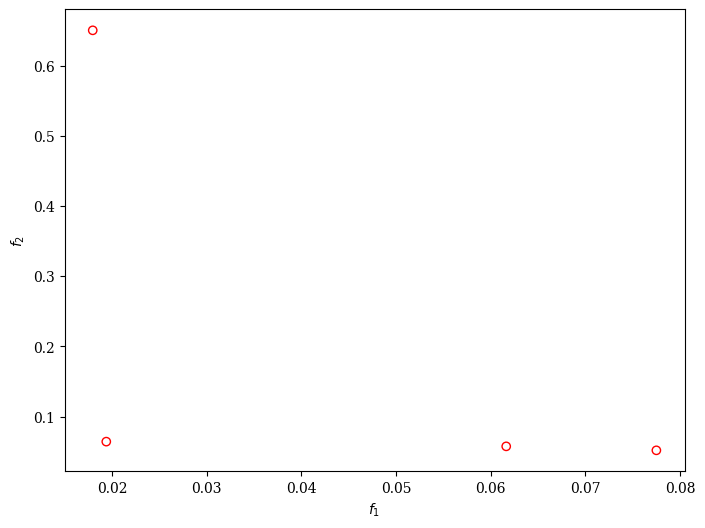

In [32]:
# Zestaw znalezionych optymalnych modeli Pareto(dokładność, szybkość)

plot = Scatter()
plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
plot.add(res.F, facecolor="none", edgecolor="red")
plot.show()

In [33]:
res.F

array([[0.06164432, 0.05762396],
       [0.01795798, 0.6504322 ],
       [0.0775089 , 0.0519578 ],
       [0.01938912, 0.06434707]])

In [57]:
# Utworzenie finalnego modelu z optymalnego zestawu parametrów

arg = res.X[0]
final_model = Sequential()
DROPOUT_VALUE = 0.1
generateModel( final_model, input_shape, arg )
final_model.summary()

Model: "sequential_208"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_575 (Dense)           (None, 1, 370)            740       
                                                                 
 dropout_992 (Dropout)       (None, 1, 370)            0         
                                                                 
 dense_576 (Dense)           (None, 1, 205)            76055     
                                                                 
 dropout_993 (Dropout)       (None, 1, 205)            0         
                                                                 
 lstm_325 (LSTM)             (None, 1, 99)             120780    
                                                                 
 dropout_994 (Dropout)       (None, 1, 99)             0         
                                                                 
 flatten_208 (Flatten)       (None, 99)             

In [58]:
# Trening finalnego modelu
training_proportion = 0.6
X_train, y_train, X_val, y_val = splitDataToTrainAndTest( processed_data, training_proportion )

final_model.compile(
    loss = MeanSquaredError(),
    optimizer=Adam(), 
    metrics=CategoricalCrossentropy())

early_stop = EarlyStopping(monitor = 'val_loss', patience = 2 )
time_measure = TimeLapseMeasureCallback()
history = final_model.fit(
    X_train, y_train,
    validation_data= (X_val, y_val),
    epochs = 100,
    callbacks=[early_stop, time_measure] )

Epoch 1/100
47/47 [==============================] - 1s 7ms/step - loss: 0.2784 - categorical_crossentropy: 2.2962e-09 - val_loss: 0.4314 - val_categorical_crossentropy: 9.2169e-09
Epoch 2/100
47/47 [==============================] - 0s 4ms/step - loss: 0.2775 - categorical_crossentropy: 2.2962e-09 - val_loss: 0.4281 - val_categorical_crossentropy: 9.2169e-09
Epoch 3/100
47/47 [==============================] - 0s 4ms/step - loss: 0.2742 - categorical_crossentropy: 2.2962e-09 - val_loss: 0.4196 - val_categorical_crossentropy: 9.2169e-09
Epoch 4/100
47/47 [==============================] - 0s 4ms/step - loss: 0.2229 - categorical_crossentropy: 2.2962e-09 - val_loss: 0.3078 - val_categorical_crossentropy: 9.2169e-09
Epoch 5/100
47/47 [==============================] - 0s 4ms/step - loss: 0.1761 - categorical_crossentropy: 2.2962e-09 - val_loss: 0.3044 - val_categorical_crossentropy: 9.2169e-09
Epoch 6/100
47/47 [==============================] - 0s 4ms/step - loss: 0.1757 - categorical_c

47/47 [==============================] - 0s 1ms/step


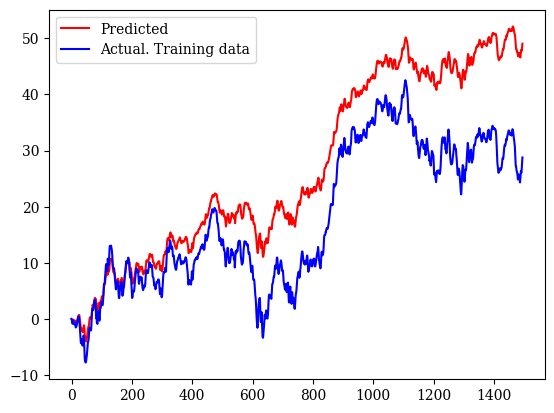

32/32 [==============================] - 0s 1ms/step


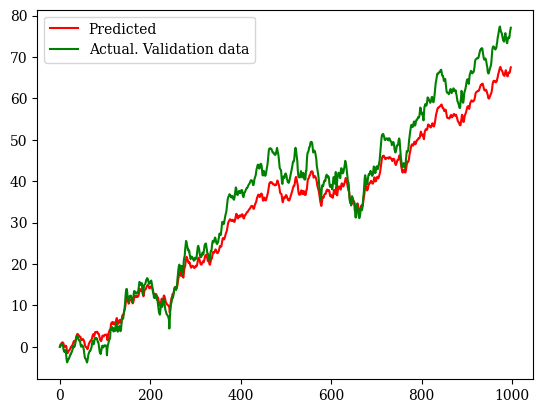

In [59]:
def integral(X, initial_state):
    result = [None]*(len(X)+1)
    result[0] = initial_state
    for i in range(1, len(result)):
        result[i] = result[i-1] + (lambda x: x[0] if type(x) == list else x )(X[i-1])
    return result

initial_state = 0

from matplotlib import pyplot as plt

# predykcja - tylko training data
X_test = X_train
y_pred = final_model.predict(X_test).flatten()
plt.plot( integral(y_pred, initial_state), 'r', label="Predicted" )
plt.plot( integral(y_train, initial_state), 'b', label="Actual. Training data")
plt.legend()
plt.show()

# predykcja - tylko validation data
X_test = X_val
y_pred = final_model.predict(X_test).flatten()
plt.plot( integral(y_pred, initial_state), 'r', label="Predicted" )
# plt.plot( [-y for y in integral(y_pred, initial_state)], 'm', label="Predicted-inverted" )
plt.plot( integral( y_val, initial_state ), 'g', label="Actual. Validation data")
plt.legend()
plt.show()